# [NML'22] assignment 1: Graph theory basics

[Ping Hu, EPFL, ASL](https://people.epfl.ch/ping.hu?lang=en) and [Arun Venkitaraman, EPFL, LTS4.](https://people.epfl.ch/arun.venkitaraman/)

## Students

* Team: `3`
* Students: `Joe Najm, Sébastien Jeanfavre`

## Rules

Grading:
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first except for the Question 4 of Section 1 (at the indicated portion only).
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this assignment is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

Let us first download the cora dataset:

In [1]:
#!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
#!tar -xvf cora.tgz

## Section 1: Network Properties

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
df = pd.read_csv('./cora/cora.content', sep='\t', header=None, index_col=0)
df.index.name = None
df.columns = range(df.shape[1])
df = df.rename(columns={1433: 'label'})
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [4]:
df.loc[:,'label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [5]:
my_field = 'Reinforcement_Learning'
features = df[df['label']==my_field].drop(columns='label').to_numpy()
features.shape

(217, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. (Needs to modify!!!)

In [6]:
distance = np.zeros((features.shape[0],features.shape[0]))

for i in range(features.shape[0]):
    for j in range(features.shape[0]):
        distance[i,j] = np.linalg.norm(features[i,:] - features[j,:])

distance.shape

(217, 217)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [7]:
mean_distance = distance.mean()
mean_distance

5.781074820974051

Plot an histogram of the euclidean distances.

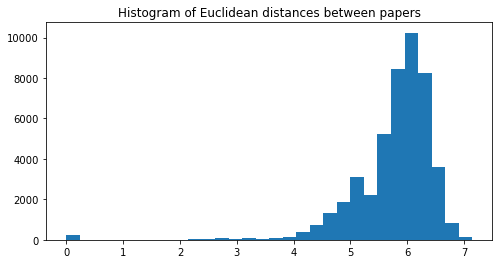

In [10]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten(), bins=30);

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

Remember that we are going to use adjacency without self-loops

In [11]:
threshold = mean_distance
A_feature = distance.copy()
A_feature[distance>=threshold] = 0
A_feature[distance<threshold] = 1
A_feature -= np.eye(A_feature.shape[0]) # remove self loops

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [12]:
cora_cites = np.genfromtxt('cora/cora.cites', delimiter='\t').astype(int)
# get graph edges and flatten them for processing

cites = pd.DataFrame(cora_cites).astype(int)
cites.columns = ['cited', 'citing']
cites.head()

,cited,citing
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [13]:
nb_papers = df.shape[0]

adj = pd.DataFrame(np.zeros((nb_papers,nb_papers))).astype(int)
adj.index = df.index
adj.columns = df.index

for i in range(cora_cites.shape[0]):
    adj.loc[cora_cites[i,1], cora_cites[i,0]] = 1

# adj is the adjacency matrix. Citing paper on rows and cited papers on columns
adj.shape

(2708, 2708)

In [14]:
# caution, we will first use the directed citation graph
A_citation = adj.to_numpy()
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [15]:
adj_RL = adj.loc[adj.index.isin(df[df['label']==my_field].index)]
adj_RL = adj_RL[df[df['label']==my_field].index]
adj_RL = adj_RL.sort_index(axis=0).sort_index(axis=1)
adj_RL_np = adj_RL.to_numpy()
adj_RL_np.shape

(217, 217)

Is the citation graph directed or undirected? In other words, is your adjacency matrix is symmetric or asymmetric? 

In [16]:
(adj_RL_np-adj_RL_np.T).any() # is there any non-zero element?

True

Since the adjacency matrix substracted by its transpose is not zero everywhere, it is not symmetric and hence the citation graph is directed.

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [17]:
num_edges_feature = np.sum(A_feature)/2 # bidirectional edges are counted as one undirected edge
num_edges_citation = np.sum(adj_RL_np) # directed edges
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 8945.0
Number of edges in the citation graph: 414


Plot the degree distribution histogram for each of the graphs.
If your graph is undirected, plot both in-degree and out-degree distributions.

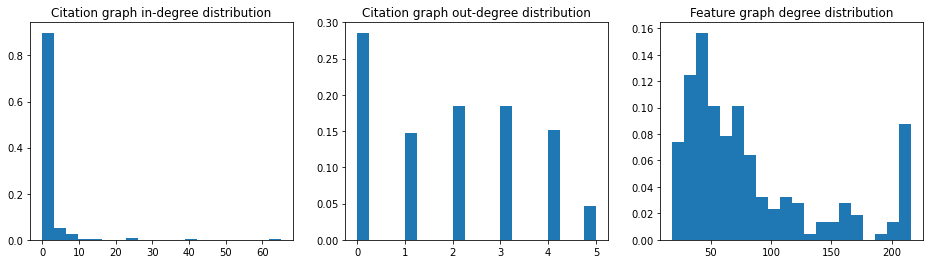

In [18]:
degrees_feature = np.sum(A_feature, axis=1)
degrees_citation_in = np.sum(adj_RL_np, axis=0)
degrees_citation_out = np.sum(adj_RL_np, axis=1)

deg_hist_normalization = np.ones(degrees_citation_in.shape[0]) / degrees_citation_in.shape[0]
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].set_title('Citation graph in-degree distribution')
axes[0].hist(degrees_citation_in, weights=deg_hist_normalization, bins=20);
axes[1].set_title('Citation graph out-degree distribution')
axes[1].hist(degrees_citation_out, weights=deg_hist_normalization, bins=20);
axes[2].set_title('Feature graph degree distribution')
axes[2].hist(degrees_feature, weights=deg_hist_normalization, bins=20);

From here onwards, we will conisider only undirected graphs.
Make the adjacency matrix symmetric for the citation graph and compute the degree distribution of the undirected citation graph.

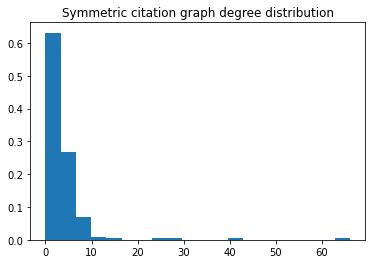

In [19]:
A_citation = np.maximum(adj_RL_np, adj_RL_np.T)
degrees_citation = np.sum(A_citation, axis=1)
plt.hist(degrees_citation, weights=deg_hist_normalization, bins=20)
plt.title('Symmetric citation graph degree distribution');


 Calculate the first and second moments of the degree distribution of each graph.

In [20]:
cit_moment_1 = 1/A_citation.shape[0] * np.sum(np.sum(A_citation, axis=0)) # np.sum(A_citation, axis=0) is the degree of each node
cit_moment_2 = 1/A_citation.shape[0] * np.sum(np.sum(A_citation, axis=0)**2)

feat_moment_1 = 1/A_feature.shape[0] * np.sum(np.sum(A_feature, axis=0))
feat_moment_2 = 1/A_feature.shape[0] * np.sum(np.sum(A_feature, axis=0)**2)

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.769585253456221
2nd moment of citation graph: 48.516129032258064
1st moment of feature graph: 82.44239631336406
2nd moment of feature graph: 10071.456221198157


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:** The first moment gives us the mean degree of the graph. The second moment gives us information about the variance of the degree since by definition the variance is the second moment substracted by the squared mean. The results we obtaind are consistent as we can observe that the degree distribution of the feature graph has a much higher variance and spreads from zero to above 200 whereas the degree distribution of the citation graph concentrates towards zero and has only few degrees higher than 10.


Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

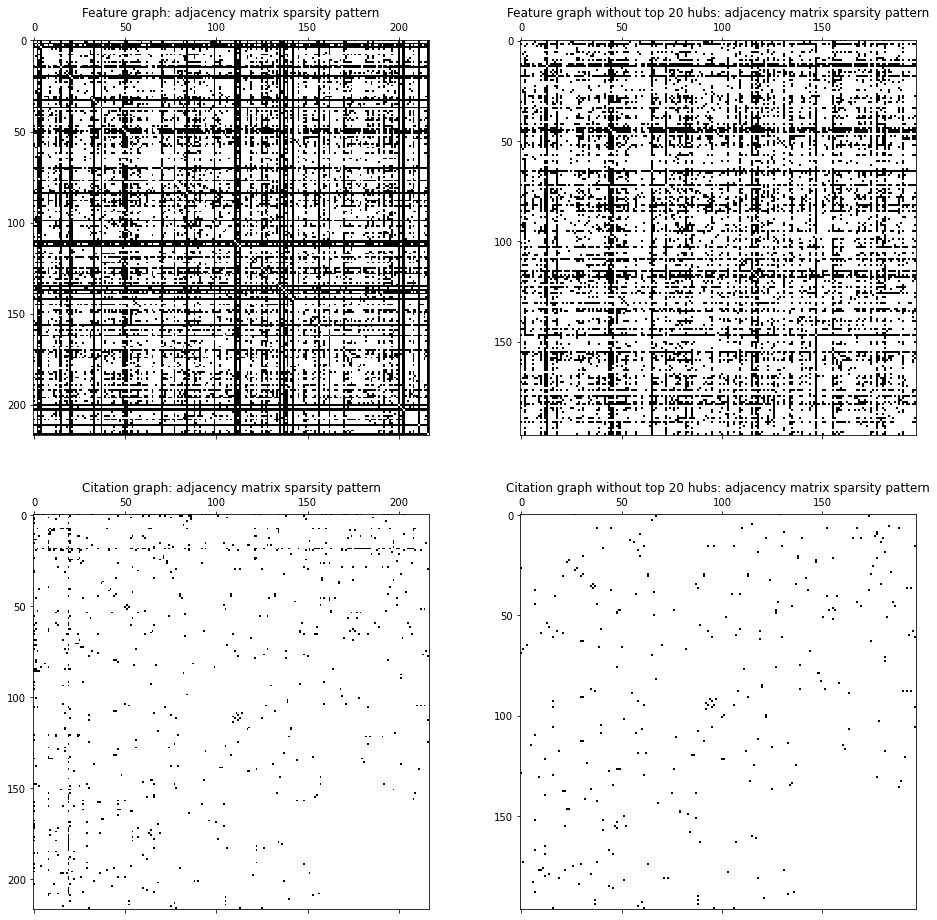

In [21]:
# get degrees of the new unordered one

sorted_deg_feature = (-degrees_feature).argsort()[:20]
del_feature = np.delete(A_feature,sorted_deg_feature,0)
reduced_A_feature = np.delete(del_feature,sorted_deg_feature,1)

sorted_deg_citation = (-degrees_citation).argsort()[:20]
del_citation = np.delete(A_citation,sorted_deg_citation,0)
reduced_A_citation = np.delete(del_citation,sorted_deg_citation,1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);


Plot the new degree distribution histograms.

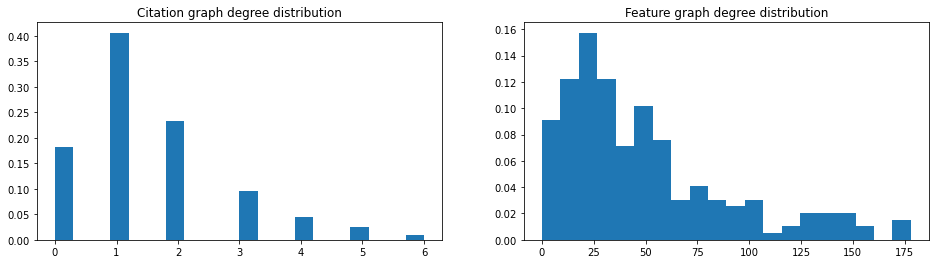

In [22]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis=1)
reduced_degrees_cit = np.sum(reduced_A_citation, axis=1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0]) / reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization, bins=20);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization, bins=20);

Compute the first and second moments for the new graphs.

In [23]:
reduced_cit_moment_1 = 1/reduced_A_citation.shape[0] * np.sum(np.sum(reduced_A_citation, axis=0)) 
reduced_cit_moment_2 = 1/reduced_A_citation.shape[0] * np.sum(np.sum(reduced_A_citation, axis=0)**2)

reduced_feat_moment_1 = 1/reduced_A_feature.shape[0] * np.sum(np.sum(reduced_A_feature, axis=0))
reduced_feat_moment_2 = 1/reduced_A_feature.shape[0] * np.sum(np.sum(reduced_A_feature, axis=0)**2)

print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.532994923857868
Citation graph second moment: 3.9390862944162435
Feature graph first moment:  49.157360406091364
Feature graph second moment:  4056.1015228426395


Print the number of edges in the reduced graphs.

In [24]:
nb_edges_cit = np.sum(reduced_A_citation)/2
nb_edges_feat = np.sum(reduced_A_feature)/2
print("Citation graph number of edges:", nb_edges_cit)
print("Feature graph number of edges:", nb_edges_feat)

Citation graph number of edges: 151.0
Feature graph number of edges: 4842.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

In [25]:
print("1st moment percentage change of citation graph: {:.2f} %".format(-(1-reduced_cit_moment_1/cit_moment_1)*100))
print("2nd moment percentage change of citation graph: {:.2f} %".format(-(1-reduced_cit_moment_2/cit_moment_2)*100))
print("1st moment percentage change of feature graph: {:.2f} %".format(-(1-reduced_feat_moment_1/feat_moment_1)*100))
print("2nd moment percentage change of feature graph: {:.2f} %".format(-(1-reduced_feat_moment_2/feat_moment_2)*100))


1st moment percentage change of citation graph: -59.33 %
2nd moment percentage change of citation graph: -91.88 %
1st moment percentage change of feature graph: -40.37 %
2nd moment percentage change of feature graph: -59.73 %


**Your answer here:** The most affected moment is the second moment of the citation graph. It removed all hubs of the citation graph, i.e. all nodes with a large degree (>10) such that its variance is reduce of 91.88%. Since there are more hubs in the feature graph, not all of them have been removed and hence the effect is much less important (-59.73%).

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [26]:
threshold = 4.246

A_feature_pruned = distance.copy()
A_feature_pruned[distance>=threshold] = 0
A_feature_pruned[distance<threshold] = 1
A_feature_pruned -= np.eye(A_feature_pruned.shape[0])
num_edges_feature_pruned = np.sum(A_feature_pruned)/2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 8945.0
Number of edges in the feature graph after pruning: 461.0
Number of edges in the citation graph: 414


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

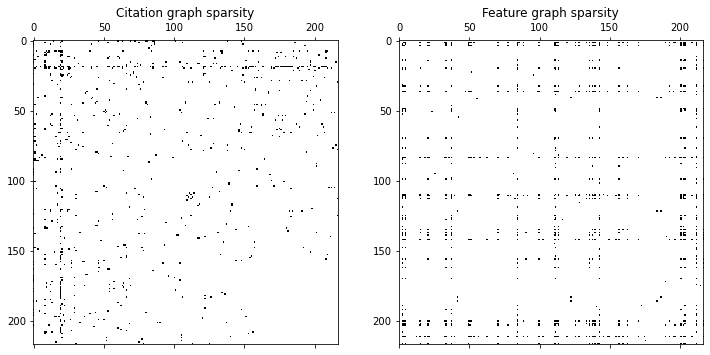

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [28]:
path_matrix_citation = np.zeros(A_citation.shape)
path_matrix_feature = np.zeros(A_feature.shape)

for i in range(10):
    path_matrix_citation += np.linalg.matrix_power(A_citation, i+1)
    path_matrix_feature += np.linalg.matrix_power(A_feature, i+1)

Check the sparsity pattern for both of path matrices.

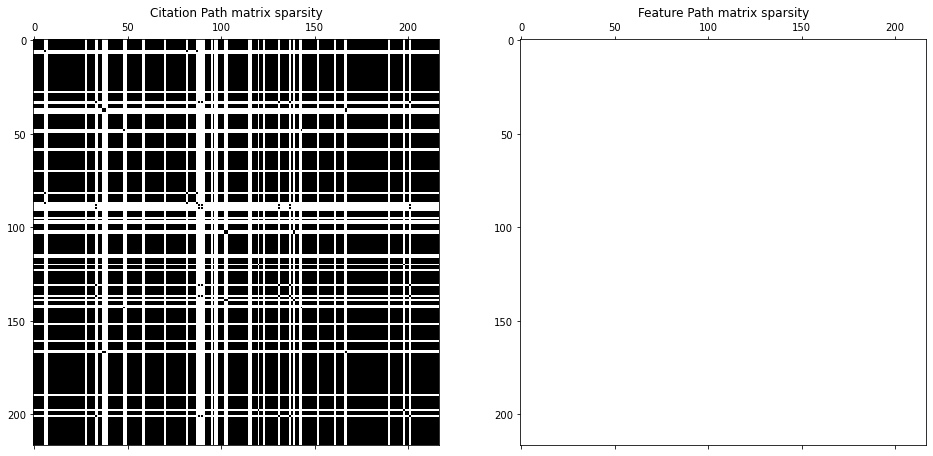

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation)
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

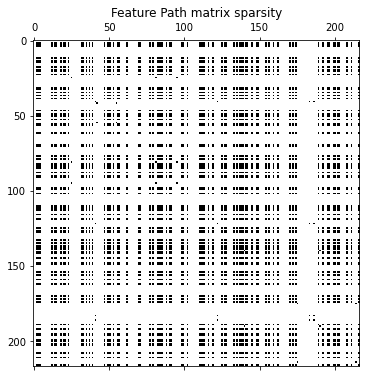

In [30]:
path_matrix_pruned = np.zeros(A_feature_pruned.shape)

for i in range(11):
    path_matrix_pruned += np.linalg.matrix_power(A_feature_pruned, i+1)
    
plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:** The pruned matrix is much sparser which makes sense since many edges have been removed. Before pruning, it was possible to go from one node to any other node in a maximum of 10 hops since the path matrix for N=10 has only non-zero entries. It is not the case anymore after pruning and some nodes are not reachable anymore within 10 hops or less.


Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** A graph is connected iff for N=number of nodes the path matrix has only non-zero entries. This means that any node can be reached from any other nodes in a maximum of N hops. The unpruned feature graph is connected since:

In [31]:
np.any(path_matrix_feature==0) # check is path_matrix_feature has zero-entries

False

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:** The diameter is the smallest N for which the path matrix is non-zero.

If any of your graphs is connected, calculate the diameter using that process.

In [32]:
path_matrix = np.zeros(A_feature.shape)

for i in range(A_feature.shape[0]):
    
    path_matrix += np.linalg.matrix_power(A_feature, i+1)
    
    if not np.any(path_matrix==0):
        diameter = i+1
        break

print(f"The diameter is: {diameter}")

The diameter is: 2


### Question 4: Shortest path

 Finding the shortest paths between agents

Here, we calculate the shortest path from a source node to a target node. A classic method for finding the shortest path on unweighted networks is Breadth-First Search (BFS) method. Check the BFS steps in the Lecture 'Graph Theory Basis'.

To this end, we first define a function for finding the neighboring nodes of a specified node x. 

In [33]:
### Get the neighboring set of node x
def find_neighbors(x):
    return [i for i in range(A_feature.shape[0]) if A_feature[x][i]>0]

Calculate the path length from the source node to the target node by filling the missing code in the algorithm: 

In [34]:
### Find the shortest path from the source node to the target node:
source_node, target_node, path_length = 0, 10, 0
source_set = [source_node]
path = []
stop_finding = 0
iteration_number = A_feature.shape[0]
i = 0
if source_node==target_node:
    stop_finding = 1
    path.append([source_node,target_node,path_length])
while stop_finding == 0 and i < iteration_number:
    source_set_new = []
    for n in source_set:
        neighbors = find_neighbors(n)
        if target_node in neighbors:
             # Code to be filled
            path.append([source_node,target_node,path_length])
            stop_finding = 1
            break
        else:
            for nn in neighbors:
                # Code to be filled
                path.append([nn,n,i])
            source_set_new += neighbors
    path_length += 1
    source_set = source_set_new.copy()
    i += 1
if stop_finding == 0:
    path_length = ['Infinity']
    shortest_path = ['None']
else:
    child_node = target_node
    shortest_path = [target_node]
    for i in range(path_length-1,-1,-1):
        parent_node = [x for [x, y, z] in path if y==child_node and z==i]
        shortest_path.append(parent_node[0])
        child_node = parent_node[0] #Select one of the parent nodes as the child node in previous round
    shortest_path.reverse()

print(f"The shortest path length from node {source_node} to node {target_node} is: {path_length}")
print(f"One shortest path is: {shortest_path}")

The shortest path length from node 0 to node 10 is: 2
One shortest path is: [2, 0, 10]


Get all edges visited by BFS starting from a source node by filling the missing lines in the following code: 

In [35]:
# All edges visited by BFS method starting from a source node
BFS_edges = []
unexplored_list = list(range(A_feature.shape[0]))
source_node = 0
source_set = [source_node]
unexplored_list.remove(source_node) 
stop_finding = 0
while stop_finding == 0:
    source_set_new = []
    for n in source_set:
        neighbors = find_neighbors(n)
        for nn in neighbors:
            if nn in unexplored_list:
                unexplored_list.remove(nn) 
                BFS_edges.append((n,nn))
                source_set_new.append(nn)
    if not source_set_new:
        stop_finding = 1      
    else:
        source_set = source_set_new.copy()
print(f"Edges visited by Breadth-First Search method starting from node {source_node}:")
list(BFS_edges)

Edges visited by Breadth-First Search method starting from node 0:


[(0, 2),
 (0, 3),
 (0, 4),
 (0, 14),
 (0, 15),
 (0, 20),
 (0, 21),
 (0, 33),
 (0, 35),
 (0, 37),
 (0, 39),
 (0, 47),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 57),
 (0, 58),
 (0, 70),
 (0, 77),
 (0, 83),
 (0, 84),
 (0, 88),
 (0, 91),
 (0, 94),
 (0, 98),
 (0, 99),
 (0, 102),
 (0, 108),
 (0, 110),
 (0, 111),
 (0, 112),
 (0, 113),
 (0, 119),
 (0, 125),
 (0, 128),
 (0, 131),
 (0, 133),
 (0, 135),
 (0, 137),
 (0, 139),
 (0, 141),
 (0, 142),
 (0, 154),
 (0, 156),
 (0, 159),
 (0, 162),
 (0, 170),
 (0, 174),
 (0, 176),
 (0, 185),
 (0, 189),
 (0, 192),
 (0, 195),
 (0, 196),
 (0, 198),
 (0, 200),
 (0, 202),
 (0, 203),
 (0, 208),
 (0, 211),
 (0, 216),
 (2, 1),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 31),
 (2, 32),
 (2, 34),
 (2, 36),
 (2, 38),
 (2, 40),
 (2, 41),
 (2, 42),
 (2, 43),
 (2, 44),
 (2, 45),
 (2, 46),
 (2, 48),
 (2,

Question: What is the difference between BFS algorithm and the Dijkstra's algorithm?

Your answer here: Dijkstra's algorithm is an extension of the BFS algorithm from unweighted networks to the weighted networks. 

Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [36]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


Let us now check our results of BFS method using NetworkX.

In [37]:
list(nx.bfs_edges(feature_graph, source_node))

[(0, 2),
 (0, 3),
 (0, 4),
 (0, 14),
 (0, 15),
 (0, 20),
 (0, 21),
 (0, 33),
 (0, 35),
 (0, 37),
 (0, 39),
 (0, 47),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 57),
 (0, 58),
 (0, 70),
 (0, 77),
 (0, 83),
 (0, 84),
 (0, 88),
 (0, 91),
 (0, 94),
 (0, 98),
 (0, 99),
 (0, 102),
 (0, 108),
 (0, 110),
 (0, 111),
 (0, 112),
 (0, 113),
 (0, 119),
 (0, 125),
 (0, 128),
 (0, 131),
 (0, 133),
 (0, 135),
 (0, 137),
 (0, 139),
 (0, 141),
 (0, 142),
 (0, 154),
 (0, 156),
 (0, 159),
 (0, 162),
 (0, 170),
 (0, 174),
 (0, 176),
 (0, 185),
 (0, 189),
 (0, 192),
 (0, 195),
 (0, 196),
 (0, 198),
 (0, 200),
 (0, 202),
 (0, 203),
 (0, 208),
 (0, 211),
 (0, 216),
 (2, 1),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 31),
 (2, 32),
 (2, 34),
 (2, 36),
 (2, 38),
 (2, 40),
 (2, 41),
 (2, 42),
 (2, 43),
 (2, 44),
 (2, 45),
 (2, 46),
 (2, 48),
 (2,

In [38]:
print(nx.shortest_path(feature_graph, source_node, target_node))

[0, 2, 10]


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [39]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section. 

In [40]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_citation), nx.number_connected_components(G_citation)))

Number of nodes: 217, Number of edges: 409
Number of self-loops: 0, Number of connected components: 28


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [41]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(nx.number_of_selfloops(G_feature), nx.number_connected_components(G_feature)))

Number of nodes: 217, Number of edges: 461
Number of self-loops: 0, Number of connected components: 136


### Question 5: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [50]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

217

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [51]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

435.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:** For a Erdös-Rényi model, we know that $<k> = \frac{2 m}{n} = p(n-1)$ with m the number of edges and n the number of nodes. Thus we get $p = \frac{2m}{n(n-1)}$

In [52]:
p = 2*m/(n*(n-1))
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [53]:
print('The Erdos-Rényi model has {} edges.'.format(G_er.size()))

The Erdos-Rényi model has 436 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:** For a Barabasi-Albert graph, we know that m = q(n-q) with q being the preferential attachment parameter. We get that $q^2 - nq + m = 0$. We solve this quadratic equation and get that q can be equal to 215 or 2.

In [54]:
q = 2
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [55]:
print('The Barabási-Albert model has {} edges.'.format(G_ba.size()))

The Barabási-Albert model has 430 edges.


### Question 6: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [56]:
giant_citation = G_citation.subgraph(max(nx.connected_components(G_citation), key=len))
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 177 nodes and 394 edges.


In [57]:
giant_feature = G_feature.subgraph(max(nx.connected_components(G_feature), key=len))
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 74 nodes and 450 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [58]:
giant_er = G_er.subgraph(max(nx.connected_components(G_er), key=len))
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 216 nodes and 436 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**  We previously saw that $<k> = p(N-1)$. We also know from the lecture that the fraction of nodes in the Giant Component is $S = \frac{N_G}{N} = 1 - e^{-<k> S}$. Thus $p = - ln(1-\frac{N_G}{N}) \frac{N}{(N-1)N_G}$

In [59]:
Ng = giant_feature.number_of_nodes()
p_new = -np.log(1-Ng/n)*(n/(Ng*(n-1)))
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [60]:
print('The new Erdos Renyi model has {} edges.'.format(G_er_new.size()))
giant_er_new = G_er_new.subgraph(max(nx.connected_components(G_er_new), key=len)) # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

The new Erdos Renyi model has 120 edges.
The giant component of the new Erdos-Rényi network has 32 nodes and 31 edges.


### Question 7: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

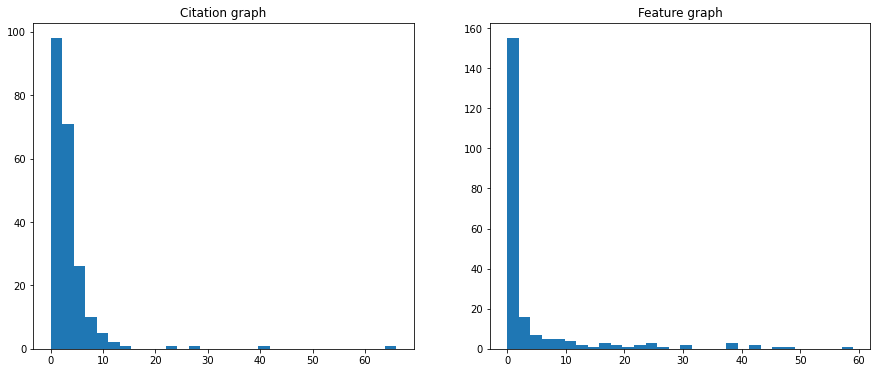

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = [G_citation.degree(n) for n in G_citation.nodes()]
axes[0].hist(citation_degrees, bins=30)
axes[1].set_title('Feature graph')
feature_degrees = [G_feature.degree(n) for n in G_feature.nodes()]
axes[1].hist(feature_degrees, bins=30);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions? 

**Your answe here:** The degree distribution tells us if there are big hubs in the network and what type of network we are dealing with (scale-free, random...). Looking at the distributions, we notice that there are lot of nodes with small degrees (less than 10) while there are a few big hubs with nodes with more than 40 edges. Hence we can say that these 2 networks might be scale free networks.

Now, plot the degree distribution historgrams for the simulated networks.

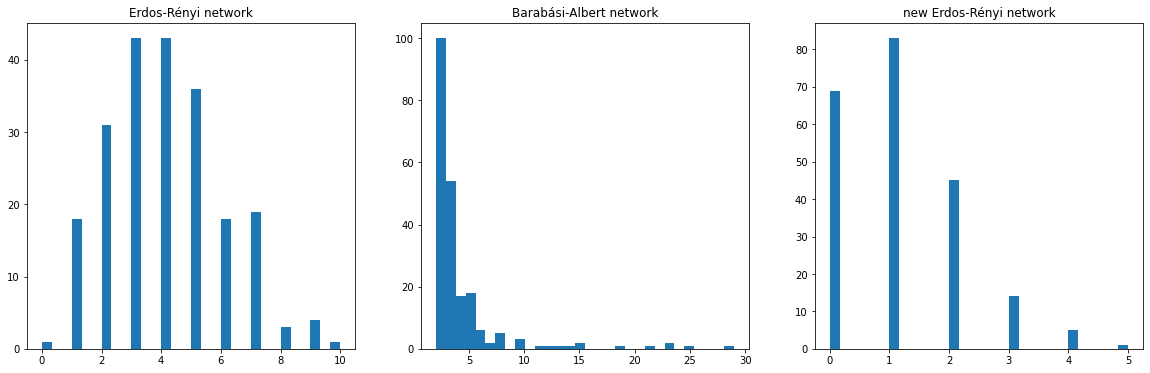

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = [G_er.degree(n) for n in G_er.nodes()]
axes[0].hist(er_degrees, bins=30);
axes[1].set_title('Barabási-Albert network')
ba_degrees = [G_ba.degree(n) for n in G_ba.nodes()]
axes[1].hist(ba_degrees, bins=30);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = [G_er_new.degree(n) for n in G_er_new.nodes()]
axes[2].hist(er_new_degrees, bins=30);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** Both Erdos-Rényi graphs don't seem to represent correctly the feature and citation graphs. However the Barabasi-Albert graph does seem to properly represent the degree distribution of the 2 original graphs. It is the degree distribution of the Barabási-Albert network that matches best the degree distribution of the citation graph.

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [63]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 217 nodes and 461 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** The informations in the new graph might not be the same as the feature graph. We might get the same degree distribution as the feature graph with the same number of giant component etc but this does not mean that it is that particular feature that has such a big number of edges. 

In [64]:
nx.number_connected_components(G_config)

131

### Question 8: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [65]:
nx.average_clustering(G_citation)

0.2653995547704223

In [66]:
nx.average_clustering(G_feature)

0.24478719794037188

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:** The clustering coefficient is an indication about the fraction of the 
node’s neighbors that are connected (probability that two neighbors of a node, are linked to each other). We get quite similar values for the citation and feature graphs at around $\frac{1}{4}$. Since the degree distributions of both graph are quite similar, it is logical to have values close to each others.

Now, let us check the average clustering coefficient for the simulated networks.

In [67]:
nx.average_clustering(G_er)

0.01375905200789993

In [68]:
nx.average_clustering(G_ba)

0.05572120854914457

In [69]:
nx.average_clustering(nx.Graph(G_config))

0.12267146772302726

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:** The new clustering coefficients are quite off compared to what the real feature and citation graphs have. The values are way smaller (even for the BA graph that had a pretty good representation of the degree distribution of the citation graph). This was expected for the Erdos-Renyi graph as it is a completely random network and has a degree distribution completely different from the feature graph. We notice that there is a small improvement for the new feature graph that follows the feature graph distribution, however its clustering coefficient is still way below the feature graph's.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:** The power_cluster_graph seems interesting as we know that the feature and citation graphs follow a powerlaw degree distribution (from the histograms previously plotted) and we can now control the average clustering coefficient in order to have one similar to the ones of the feature and citation graphs (around 0.25).

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

There are 430 edges in this new powerlaw graph
The average clustering coefficient is 0.24756826728852677


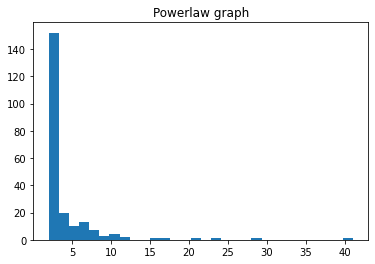

In [70]:
# Your code here.

q = 2
p = 0.25  # Probability of adding a triangle after adding a random edge : value chosen experimentally
G_powerlaw = nx.powerlaw_cluster_graph(n, q, p)

print(f"There are {G_powerlaw.size()} edges in this new powerlaw graph")
print(f"The average clustering coefficient is {nx.average_clustering(G_powerlaw)}")

plt.figure()
plt.title("Powerlaw graph")
plt.hist([degree for node, degree in G_powerlaw.degree()], bins=30);


Comment on the similarities of your match.

**Your answer here:** We previously saw that the average number of edges between the feature and citation graphs is 435 edges. We now have a quite similar number : 430. For the clustering coefficient, we now have a much better value as we are in a range between 0.2 and 0.3 and we originally wanted 0.25. Finally the degree distribution matches the ones of the feature and citation graphs. To conclude, we can say that this new model is an extension to the Barabasi Albert graph as the degree distribution follows a power law, it has a good number of edges and on top of that we obtain a correct average clustering coefficient.